<h1>NOTE: The dataset used in this notebook is not available for download or creation, as it was an earlier iteration of the demographics modeling notebooks. This will likely not run!</h1>

# Capstone Modeling: Maternal Morbidity Risk Patterns (2014–2024)

This notebook showcases the modeling workflow used to examine how demographic, prenatal, and historical reproductive factors relate to maternal morbidity using U.S. Natality data from 2011–2024. Because the raw natality files vary substantially in structure and content across years, a significant data engineering effort was required to align schemas, normalize fields, and construct a unified analytic dataset. The historical record of this processing work is preserved in the final section for transparency, but those cells are not executed here.

The active modeling portion of this notebook focuses on:

1. Loading the consolidated natality file produced during earlier ETL work.

2. Constructing a clean and balanced modeling dataset using 100,000 births sampled from each analysis year (2014, 2016, 2018, 2020, 2022, 2024).

3. Engineering demographic variables, prenatal indicators, and the maternal morbidity outcome.

4. Training an XGBoost model to examine associations between these variables and morbidity risk.

5. Interpreting model behavior using SHAP values to identify population-level vulnerability patterns.

6. Building an extended model that incorporates education and reproductive history to assess whether a richer feature set produces stronger predictive signals.

The notebook is designed to provide a clear, reproducible modeling pipeline while also maintaining visibility into the earlier stages of data engineering that made the analysis possible.

#_____________________________________________________________________________

# 1. Environment Setup

This section mounts Google Drive and sets the base paths for the project.
Only this block should be executed to configure the environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Capstone-MADS/SS_Notebooks"


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/189ZLBwtxhIzBPvvveai-IblNQ9E5XJkw/Capstone-MADS/SS_Notebooks


#_____________________________________________________________________________

# 2. Load Aligned Dataset
This section defines the dataset path and confirms the columns we'll be using for our model.


In [ ]:
from pathlib import Path
import pandas as pd

BASE = Path("/content/drive/MyDrive/Capstone-MADS/Datasets/natality_data/aligned")
aligned_path = BASE / "natality_2011_2024_aligned_all.csv"

print("Using aligned dataset:", aligned_path)

raw_cols = [
    "no_mmorb",      # morbidity indicator
    "dob_yy",        # birth year
    "mager",         # mother age
    "fagecomb",      # father age
    "mbrace",        # mother race
    "mhisp_r",       # mother hispanic
    "fbrace",        # father race
    "fhisp_r",       # father hispanic
    "precare",       # prenatal month
    "previs"         #  prenatal visits
]

header = pd.read_csv(aligned_path, nrows=0)
available_cols = header.columns.tolist()
raw_cols = [c for c in raw_cols if c in available_cols]

print("Columns being used:", raw_cols)


Using aligned dataset: /content/drive/MyDrive/Capstone-MADS/Datasets/natality_data/aligned/natality_2011_2024_aligned_all.csv
Columns being used: ['no_mmorb', 'dob_yy', 'mager', 'fagecomb', 'mbrace', 'mhisp_r', 'fbrace', 'fhisp_r', 'precare', 'previs']


#_____________________________________________________________________________

# 3. Build Modeling Sample
This section constructs a balanced dataset by sampling 100,000 rows from each
of the target years (2014, 2016, 2018, 2020, 2022, 2024). It also:
- Recreates morbidity labels
- Reconstructs demographic variables
- Generates prenatal care fields

This produces `df`, the dataset used for modeling.


In [ ]:
import pandas as pd
import numpy as np

years_to_sample = [2014, 2016, 2018, 2020, 2022, 2024]
rows_per_year = 100_000
chunk_size = 300_000

samples = {yr: [] for yr in years_to_sample}
counts = {yr: 0 for yr in years_to_sample}

race_map = {
    1.0: "White",
    2.0: "Black",
    3.0: "AIAN",
    4.0: "Asian/PI",
    5.0: "Multiple/Other",
    9.0: "Unknown",
    99.0: "Unknown"
}

def map_hisp(x):
    if pd.isna(x):
        return np.nan
    try:
        v = int(x)
    except:
        return np.nan
    if v == 0:
        return 0
    if v in (1, 2, 3, 4, 5):
        return 1
    return np.nan

for chunk in pd.read_csv(aligned_path, usecols=raw_cols, chunksize=chunk_size, low_memory=False):

    chunk["birth_year"] = pd.to_numeric(chunk["dob_yy"], errors="coerce")

    chunk = chunk[chunk["birth_year"].isin(years_to_sample)]
    if chunk.empty:
        continue

    mm = pd.to_numeric(chunk["no_mmorb"], errors="coerce")
    chunk["maternal_morbidity"] = mm.map({0: 1, 1: 0})

    chunk["mother_age"] = pd.to_numeric(chunk["mager"], errors="coerce")
    fa = pd.to_numeric(chunk["fagecomb"], errors="coerce").replace(99, np.nan)
    chunk["father_age"] = fa




    chunk["mother_race"] = pd.to_numeric(chunk["mbrace"], errors="coerce").map(race_map)
    chunk["father_race"] = pd.to_numeric(chunk["fbrace"], errors="coerce").map(race_map)

    # Hispanic flags
    chunk["mother_hispanic"] = chunk["mhisp_r"].apply(map_hisp)
    chunk["father_hispanic"] = chunk["fhisp_r"].apply(map_hisp)

    pm = pd.to_numeric(chunk["precare"], errors="coerce").replace(99, np.nan)
    pv = pd.to_numeric(chunk["previs"], errors="coerce").replace(99, np.nan)
    chunk["prenatal_start_month"] = pm
    chunk["prenatal_total_visits"] = pv

    #  essential modeling columns
    keep_cols = [
        "maternal_morbidity",
        "birth_year",
        "mother_age", "father_age",
        "mother_race", "mother_hispanic",
        "father_race", "father_hispanic",
        "prenatal_start_month", "prenatal_total_visits"
    ]
    chunk = chunk[keep_cols]

    # Sample target rows for each year
    for yr in years_to_sample:
        if counts[yr] >= rows_per_year:
            continue

        year_chunk = chunk[chunk["birth_year"] == yr]
        if year_chunk.empty:
            continue

        needed = rows_per_year - counts[yr]
        take = year_chunk.iloc[:needed]

        samples[yr].append(take)
        counts[yr] += len(take)

    if all(counts[yr] >= rows_per_year for yr in years_to_sample):
        break

# Final modeling dataset
df = pd.concat([pd.concat(samples[yr]) for yr in years_to_sample], ignore_index=True)

print("\nRows per year:")
print(df["birth_year"].value_counts())

print("\nFinal shape:", df.shape)
df.head()



Rows per year:
birth_year
2014    100000
2016    100000
2018    100000
2020    100000
2022    100000
2024    100000
Name: count, dtype: int64

Final shape: (600000, 10)


,maternal_morbidity,birth_year,mother_age,father_age,mother_race,mother_hispanic,father_race,father_hispanic,prenatal_start_month,prenatal_total_visits
0,0.0,2014,29,35.0,White,0.0,White,0.0,3.0,9.0
1,0.0,2014,25,NaN,AIAN,0.0,Unknown,NaN,7.0,8.0
2,0.0,2014,21,22.0,White,0.0,White,0.0,2.0,12.0
3,0.0,2014,22,NaN,Black,0.0,Unknown,NaN,3.0,9.0
4,0.0,2014,25,25.0,White,0.0,White,0.0,3.0,9.0


#_____________________________________________________________________________

# 4. Preprocessing for Modeling
This cell's main function is to:
- Drop missing outcomes
- Split (`X`, `y`)
- Encode categorical variables
- Handle numeric imputation


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

df_model = df.dropna(subset=["maternal_morbidity"]).copy()

y = df_model["maternal_morbidity"].astype(int)

X = df_model.drop(columns=["maternal_morbidity"])

cat_cols = ["mother_race", "father_race"]
num_cols = [c for c in X.columns if c not in cat_cols]

X = pd.get_dummies(X, columns=cat_cols, dummy_na=True)

for c in num_cols:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
        X[c] = X[c].fillna(X[c].median())


print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts())


X shape: (599530, 18)
y distribution:
maternal_morbidity
0    591823
1      7707
Name: count, dtype: int64


#_____________________________________________________________________________

# 5. Train XGBoost Model
We train a tree-based model on the cleaned dataset and evaluate performance using AUC.


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist"
)

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
print("Validation AUC:", round(auc, 3))


Validation AUC: 0.57


### Model Performance (AUC Interpretation)

The XGBoost model achieved an AUC of approximately **0.57**, which indicates that demographic and prenatal variables alone provide **limited predictive value** for identifying maternal morbidity on an individual basis.

An AUC close to 0.5 suggests performance near random guessing, while an AUC closer to 1.0 would indicate to us that there's a strong discriminative power. With an AUC of 0.57, the model essentially demonstrated that there is *some* statistical signal present, but not enough to support clinical prediction
or individual-level risk scoring.

This result is still consistent with our expectations: maternal morbidity is a highly complex and multifactorial outcome that cannot be reliably predicted using demographics alone. However, even with limited predictive strength, the model still enables meaningful pattern discovery through feature attribution techniques like **SHAP**.


#_____________________________________________________________________________

# 6.1 SHAP Feature Interpretation
This section computes SHAP values for the trained XGBoost model to understand
population vulnerability patterns. Only a subset is used for memory efficiency.


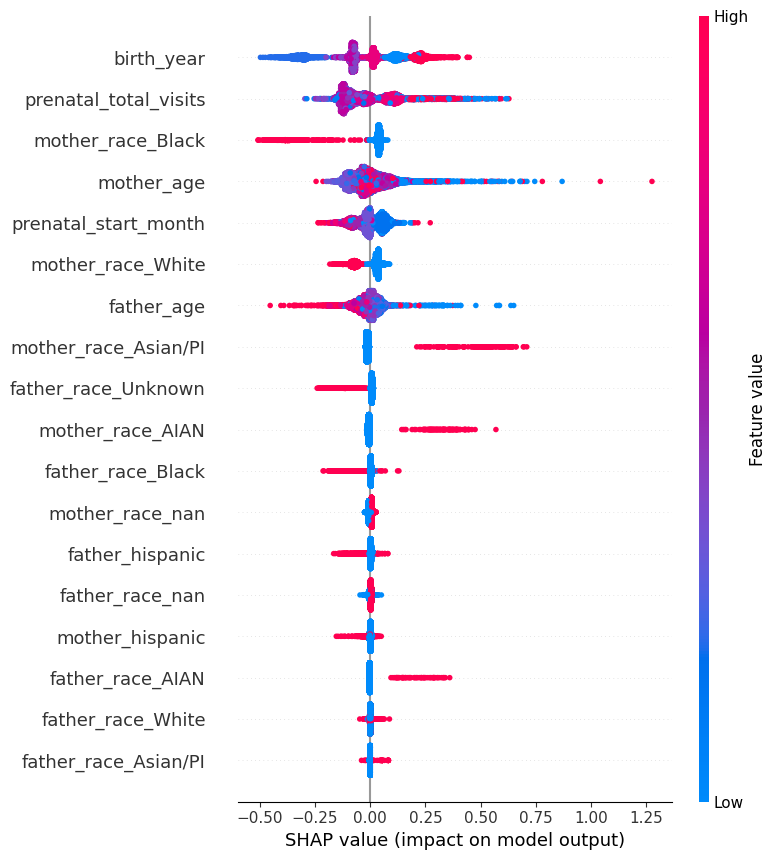

In [ ]:
#!pip install shap

import shap

shap.initjs()

X_shap = X_test.iloc[:10_000].copy()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)


#6.2. SHAP Interpretation

The SHAP results show that demographics by themselves don’t predict maternal morbidity very well, but we can still see some clear patterns in how the model is making decisions.

##*Prenatal care is the dominant clinical factor.*
People who start prenatal care later or have fewer visits consistently get higher predicted risk. More visits lowers the model’s risk score. This is a strong signal.

##*Age also plays a role.*
Higher maternal age tends to push risk up, though the effect is smaller than prenatal care.

##*Race shows population-level trends, not individual predictions.*
Being classified as Black increases predicted risk slightly, while being White decreases it, but it's still not conclusive. The other race categories have similar weak effects. These are broad population patterns, not something the model can use reliably for prediction.

##*Father information barely contributes.*
Father race, age, and Hispanic indicators have almost no impact on the model.

##*Birth year mostly reflects changes over time.*
It influences the model significantly, likely because healthcare systems and reporting changed across years, not because the year itself predicts individual biological risk.

**Overall**: The SHAP plot confirms that demographics alone aren't strong predictors, but prenatal care timing and maternal age do show real, meaningful associations with higher or lower risk.

#_____________________________________________________________________________

#7. Extended Feature Modeling: Education and Obstetric History

This section expands the original model by incorporating additional factors that may influence maternal morbidity, including parental education levels and prior pregnancy outcomes (prior live births, prior fetal losses, and prior terminations). These variables represent conditions present before the current pregnancy and may help clarify baseline maternal risk beyond demographics and prenatal care alone.

The following cells:

Identify which extended variables are available in the aligned dataset.

Rebuild the sampling pipeline to include these additional features.

Train an updated XGBoost model using the expanded feature set.

Interpret the new SHAP results to understand how reproductive history and education contribute to predicted risk.

#7.1 Identify Available Extended Variables

This cell checks which additional features like education and prior pregnancy outcomes being present in the aligned dataset.

In [ ]:
# Check which extra variables in aligned dataset
extra_cols = [
    "meduc",        # mother education
    "feduc",        # father education
    "priorlive",    # prior live births
    "priordead",    # prior dead births
    "priorterm",    # prior terminations
    "rf_inf_pelv",  # pelvic infection
    "rf_inf_sex",   # sexually transmitted infection
    "rf_inf_chorio",# chorioamnionitis
    "rf_inf_other"  # other maternal infections
]

header = pd.read_csv(aligned_path, nrows=0).columns
available_extra = [c for c in extra_cols if c in header]

print("Extra columns available:", available_extra)


Extra columns available: ['meduc', 'feduc', 'priorlive', 'priordead', 'priorterm']


#7.2 Construct Extended Raw Column List

This cell appends the newly available variables to the original raw column list.


In [ ]:
# extended raw column list for alternative modeling
raw_cols_extended = raw_cols + available_extra
print("Extended raw columns:", raw_cols_extended)


Extended raw columns: ['no_mmorb', 'dob_yy', 'mager', 'fagecomb', 'mbrace', 'mhisp_r', 'fbrace', 'fhisp_r', 'precare', 'previs', 'meduc', 'feduc', 'priorlive', 'priordead', 'priorterm']


#7.3 Build Alternative Modeling Sample
This cell reconstructs the multi-year modeling dataset using the extended variables.
It applies the same sampling strategy as the primary model but includes education and prior-birth factors.
The output is df_alt which is a 600,000-row dataset parallel to the original df.

In [ ]:
# Build Alternative Dataset includes: Education, Prior Births, Race, Hispanic Flags, Ages

samples_alt = {yr: [] for yr in years_to_sample}
counts_alt = {yr: 0 for yr in years_to_sample}

for chunk in pd.read_csv(
    aligned_path,
    usecols=raw_cols_extended,
    chunksize=chunk_size,
    low_memory=False
):

    # Birth Year Filter
    chunk["birth_year"] = pd.to_numeric(chunk["dob_yy"], errors="coerce")
    chunk = chunk[chunk["birth_year"].isin(years_to_sample)]
    if chunk.empty:
        continue

    # Maternal Morbidity
    mm = pd.to_numeric(chunk["no_mmorb"], errors="coerce")
    chunk["maternal_morbidity"] = mm.map({0: 1, 1: 0})

    # Age
    chunk["mother_age"] = pd.to_numeric(chunk["mager"], errors="coerce")
    chunk["father_age"] = pd.to_numeric(chunk["fagecomb"], errors="coerce").replace(99, np.nan)

    # Race & Hispanic Mapping
    chunk["mother_race"] = pd.to_numeric(chunk["mbrace"], errors="coerce").map(race_map)
    chunk["father_race"] = pd.to_numeric(chunk["fbrace"], errors="coerce").map(race_map)

    chunk["mother_hispanic"] = chunk["mhisp_r"].apply(map_hisp)
    chunk["father_hispanic"] = chunk["fhisp_r"].apply(map_hisp)

    # Prenatal Care
    chunk["prenatal_start_month"] = pd.to_numeric(chunk["precare"], errors="coerce").replace(99, np.nan)
    chunk["prenatal_total_visits"] = pd.to_numeric(chunk["previs"], errors="coerce").replace(99, np.nan)

    # Education
    chunk["mother_education"] = pd.to_numeric(chunk.get("meduc"), errors="coerce").replace(99, np.nan)
    chunk["father_education"] = pd.to_numeric(chunk.get("feduc"), errors="coerce").replace(99, np.nan)

    # Prior Birth History
    for col in ["priorlive", "priordead", "priorterm"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors="coerce").replace(99, np.nan)

    # Final columns to keep
    keep_alt = [
        "maternal_morbidity",
        "birth_year",
        "mother_age", "father_age",
        "mother_race", "mother_hispanic",
        "father_race", "father_hispanic",
        "prenatal_start_month", "prenatal_total_visits",
        "mother_education", "father_education",
        "priorlive", "priordead", "priorterm"
    ]

    keep_alt = [c for c in keep_alt if c in chunk.columns]
    chunk = chunk[keep_alt]

    for yr in years_to_sample:
        if counts_alt[yr] >= rows_per_year:
            continue

        year_chunk = chunk[chunk["birth_year"] == yr]
        if year_chunk.empty:
            continue

        needed = rows_per_year - counts_alt[yr]
        take = year_chunk.iloc[:needed]

        samples_alt[yr].append(take)
        counts_alt[yr] += len(take)

    if all(counts_alt[yr] >= rows_per_year for yr in years_to_sample):
        break

# Final Alternative Modeling Dataset
df_alt = pd.concat([pd.concat(samples_alt[yr]) for yr in years_to_sample], ignore_index=True)

print("New dataset shape:", df_alt.shape)
df_alt.head()


New dataset shape: (600000, 15)


,maternal_morbidity,birth_year,mother_age,father_age,mother_race,mother_hispanic,father_race,father_hispanic,prenatal_start_month,prenatal_total_visits,mother_education,father_education,priorlive,priordead,priorterm
0,0.0,2014,29,35.0,White,0.0,White,0.0,3.0,9.0,7,4,1.0,0.0,0.0
1,0.0,2014,25,NaN,AIAN,0.0,Unknown,NaN,7.0,8.0,3,9,2.0,0.0,0.0
2,0.0,2014,21,22.0,White,0.0,White,0.0,2.0,12.0,4,3,0.0,0.0,2.0
3,0.0,2014,22,NaN,Black,0.0,Unknown,NaN,3.0,9.0,5,9,0.0,0.0,1.0
4,0.0,2014,25,25.0,White,0.0,White,0.0,3.0,9.0,5,4,2.0,0.0,0.0


#7.4 Prepare Features for Extended Model

This cell performs feature engineering for the extended dataset:

* Creates the target variable

* Encodes categorical features

* Converts numeric fields

* Handles missing values


This produces X_alt and y_alt, ready for modeling.

In [ ]:
# Prep features for new model
df_alt_model = df_alt.dropna(subset=["maternal_morbidity"]).copy()

y_alt = df_alt_model["maternal_morbidity"].astype(int)
X_alt = df_alt_model.drop(columns=["maternal_morbidity"])

cat_cols_alt = ["mother_race", "father_race"]
X_alt = pd.get_dummies(X_alt, columns=cat_cols_alt, dummy_na=True)

for col in X_alt.columns:
    X_alt[col] = pd.to_numeric(X_alt[col], errors="ignore")

X_alt = X_alt.fillna(X_alt.median())

print("X_alt shape:", X_alt.shape)


/tmp/ipython-input-2545717192.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_alt[col] = pd.to_numeric(X_alt[col], errors="ignore")


X_alt shape: (599530, 23)


#7.5 Train Extended XGBoost Model

This cell trains an updated XGBoost classifier using the extended feature set.
Model performance is evaluated using AUC to compare improvements from adding obstetric history and education.

In [ ]:
# Train extended-feature model

X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(
    X_alt, y_alt, test_size=0.2, random_state=0, stratify=y_alt
)

model_alt = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist"
)

model_alt.fit(X_train_alt, y_train_alt)

probs_alt = model_alt.predict_proba(X_test_alt)[:, 1]
auc_alt = roc_auc_score(y_test_alt, probs_alt)

print("Extended-model AUC:", round(auc_alt, 3))


Extended-model AUC: 0.671


# Extended Model Performance Interpretation

The extended-feature model achieved an AUC of 0.671, a clear improvement over the demographic-only model (AUC ≈ 0.57). While still not suited for individual prediction, this higher AUC indicates that adding education and obstetric history provides stronger population-level signal. Because of this improvement, we will proceed with SHAP analysis to understand how these added features shape risk patterns.

#7.6 SHAP Interpretation for Extended Model

This cell computes SHAP values for the extended model to understand how the new features (education and prior births) influence risk predictions.
It provides a population-level interpretation of the additional variables.

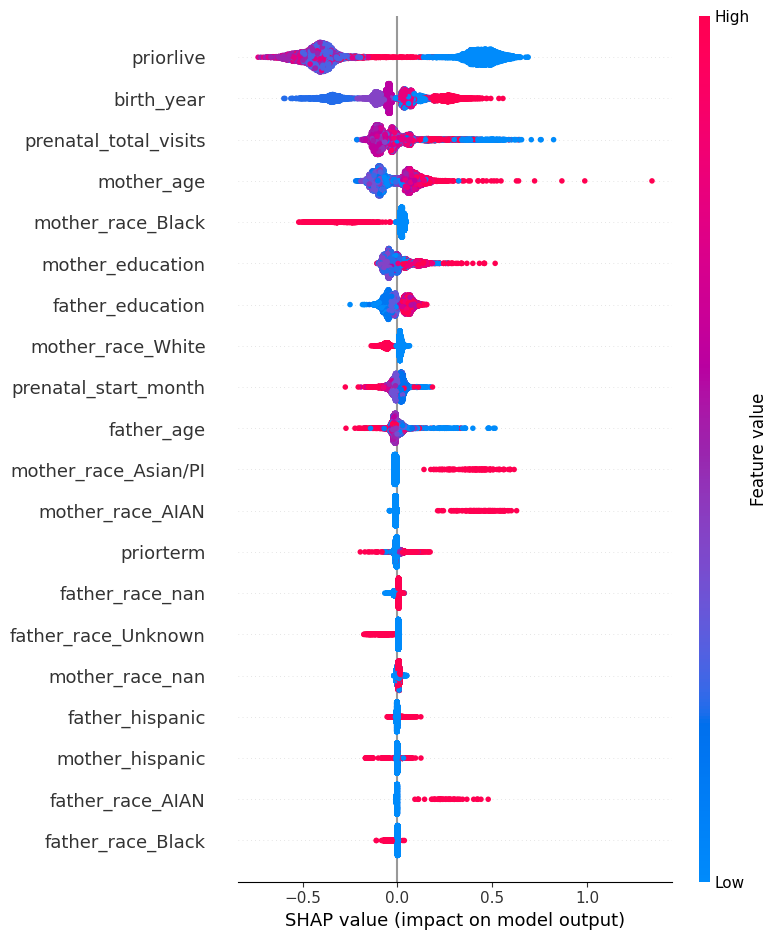

In [ ]:
# SHAP for extended-feature model
X_shap_alt = X_test_alt.iloc[:10_000].copy()

explainer_alt = shap.TreeExplainer(model_alt)
shap_values_alt = explainer_alt.shap_values(X_shap_alt)

shap.summary_plot(shap_values_alt, X_shap_alt)


# 7.6.1 SHAP Interpretation for Extended Model

The SHAP results highlight several key relationships:

##*Prior live births (priorlive)*
This is the strongest factor.
• First-time mothers (low values) shift risk higher.
• Mothers with multiple prior births (high values) shift risk lower.
This pattern aligns with the well-established “healthy mom effect,” where mothers who have already had successful pregnancies tend to experience fewer acute complications. First-time pregnancies, conversely, carry higher baseline risk for conditions such as preeclampsia and prolonged labor.

##*Birth year (birth_year)*
More recent years correspond to higher predicted risk, likely due to improved detection and system-level reporting changes rather than biological shifts.

##*Education (mother_education)*
Effects are mixed but suggest that higher education may proxy delayed childbearing, which is associated with slightly higher risk.

##*Prior pregnancy losses (priorterm)*
Weak/mixed signal

##*Prenatal visits (prenatal_total_visits)*
Higher visit counts remain protective, consistent with clinical expectations.

#Closing Remarks

This notebook outlines the full process used to prepare, sample, and model maternal morbidity patterns from the U.S. Natality dataset. The demographic-only model demonstrated limited predictive strength (AUC ≈ 0.57), confirming that basic demographics cannot reliably predict individual maternal outcomes. However, expanding the feature set to include education and prior pregnancy history substantially improved performance (AUC ≈ 0.671), revealing clearer population-level vulnerability patterns—particularly elevated risk among first-time mothers and consistent protective effects from increased prenatal care.

These findings tell us that demographic and historical factors are useful for understanding broad trends but should not be interpreted as individualized risk predictions. The analysis is intended to support population insights, not clinical decision-making.

The following Historical Data Engineering section preserves the full workflow used to align, normalize, and consolidate the raw natality files into a unified dataset. This material remains non-executing but serves as documentation of the underlying data preparation pipeline that enabled all modeling work presented above.

#_____________________________________________________________________________

#_____________________________________________________________________________

# Historical Data Engineering (Do Not Run)
The following blocks represent earlier data cleaning, alignment, validation,
and exploratory analysis used during the development of the project.

They are preserved for capstone documentation but should **NOT** be executed
because:
- they operate on 46M-row datasets
- they require hours to run
- they rebuild files that already exist

All cells in this section are fully commented out at your convenience.


#Part 1 — Alignment and Merging

These cells correspond to the construction of the unified natality dataset before modeling.
They document schema inspection, normalization, and high-performance merging across years.

In [ ]:
# Identifies all yearly natality files and captures header variations across years.


# from pathlib import Path
# import pandas as pd
# import numpy as np
# import re

# BASE = Path("/content/drive/MyDrive/Capstone-MADS/Datasets/natality_data")
# OUT  = BASE / "aligned"
# OUT.mkdir(exist_ok=True, parents=True)

# # collect all natality CSVs
# files = sorted(list(BASE.glob("natality*.csv")))
# print(len(files), "files found")
# print([f.name for f in files])

# # inspect per-year schemas (headers lowercased/stripped)
# schemas = {}
# for f in files:
#     yr = re.search(r"(\d{4})", f.name).group(1)
#     cols = pd.read_csv(f, nrows=0, low_memory=False).columns
#     schemas[yr] = pd.Index([c.strip().lower() for c in cols])

# # union of columns across years
# all_cols = pd.Index(sorted(set().union(*schemas.values())))
# print("Union column count:", len(all_cols))
# pd.DataFrame({y: pd.Series(1, index=schemas[y]) for y in sorted(schemas)}).fillna(0).head(20)

In [ ]:
# Defines helper functions used to standardize column names and clean sentinel values.


# # Minimal alias map for header drift.
# ALIAS = {
#     "no_mmorb ": "no_mmorb",
# }

# def norm_cols(cols: pd.Index) -> pd.Index:
#     """Lowercase, strip, and apply simple aliases."""
#     return pd.Index([ALIAS.get(c.strip().lower(), c.strip().lower()) for c in cols])

# # Common sentinel values observed in natality files
# SENTINELS = {
#     "fagecomb": [99],
#     "priorlive": [99],
#     "priordead": [99],
#     "priorterm": [99],
#     "precare": [99],
#     "previs": [99],
#     "cig_0": [99], "cig_1": [99], "cig_2": [99], "cig_3": [99],
#     "wtgain": [99],
#     "rf_cesarn": [99],
#     "combgest": [99],
#     "pwgt_r": [999], "dwgt_r": [999], "dbwt": [999],
#     "bmi": [99.9],
# }

# def apply_sentinels(df: pd.DataFrame) -> pd.DataFrame:
#     """Replace known sentinel codes with NaN. Also drop implausible BMI > 90."""
#     for col, bads in SENTINELS.items():
#         if col in df.columns:
#             df[col] = pd.to_numeric(df[col], errors="ignore")
#             for bad in bads:
#                 df[col] = df[col].replace(bad, np.nan)
#             if col == "bmi":
#                 df.loc[pd.to_numeric(df["bmi"], errors="coerce") > 90, "bmi"] = np.nan
#     return df

In [ ]:
# Contains the alignment code that harmonized column structure across years.


# import pandas as pd, gc, re, time
# from pathlib import Path

# CHUNK = 500_000

# def align_one_year_with_progress(in_path: Path, out_path: Path, year: str):
#     """Align a single CSV (header normalize + add missing cols + reorder), chunked with progress prints."""
#     t0 = time.time()
#     if out_path.exists():
#         out_path.unlink()

#     rows_written = 0
#     first = True
#     chunk_idx = 0

#     print(f"\n[{year}] starting {in_path.name}")
#     for chunk in pd.read_csv(in_path, chunksize=CHUNK, low_memory=False, dtype="object"):
#         # normalizing headers
#         chunk.columns = norm_cols(chunk.columns)

#         missing = [c for c in all_cols if c not in chunk.columns]
#         if missing:
#             for m in missing:
#                 chunk[m] = pd.NA

#         chunk = chunk.reindex(columns=all_cols)

#         chunk.to_csv(out_path, index=False, mode="a", header=first)
#         first = False
#         rows_written += len(chunk)
#         chunk_idx += 1

#         if chunk_idx % 2 == 0:
#             elapsed = time.time() - t0
#             print(f"[{year}] chunks={chunk_idx}  rows≈{rows_written:,}  elapsed={elapsed:,.1f}s")

#         del chunk
#         gc.collect()

#     print(f"[{year}] done → {out_path.name}  rows={rows_written:,}  total time={time.time()-t0:,.1f}s")
#     return {"year": year, "rows": rows_written, "file": out_path.name, "seconds": round(time.time()-t0,1)}

# manifest = []
# for f in files:
#     yr = re.search(r"(\d{4})", f.name).group(1)
#     if yr == "2011":
#         continue  # skip, already aligned
#     out_f = OUT / f.name
#     try:
#         info = align_one_year_with_progress(f, out_f, yr)
#         manifest.append(info)
#     except Exception as e:
#         print(f"[{yr}] ERROR: {e}")

# pd.DataFrame(manifest).sort_values("year")


In [ ]:
# Implements a streaming-based merge to create the combined


# import os, time, shutil

# combined_path = OUT / "natality_2011_2024_aligned_all.csv"
# if combined_path.exists():
#     combined_path.unlink()

# aligned_files = sorted(OUT.glob("natality*.csv"))
# assert aligned_files, "No aligned files found"

# start = time.time()


# with open(aligned_files[0], "r", encoding="utf-8") as src, open(combined_path, "w", encoding="utf-8") as dst:
#     header = src.readline()
#     dst.write(header)


# for i, f in enumerate(aligned_files, start=1):
#     with open(f, "r", encoding="utf-8") as src, open(combined_path, "a", encoding="utf-8") as dst:
#         _ = src.readline()
#         shutil.copyfileobj(src, dst, length=8 * 1024 * 1024)
#     if i % 2 == 0:
#         print(f"Appended {i}/{len(aligned_files)} files…")

# elapsed = time.time() - start
# print("Combined file saved to:", combined_path)
# print(f"Elapsed: {elapsed:,.1f}s")


# Part 2 — Data Quality Checks (Audit Phase)

These cells were used after dataset construction to verify correctness and understand variable structure.

In [ ]:
## Examines which fields relate to race, Hispanic origin, and prenatal care.

# cols = pd.read_csv(combined_path, nrows=0).columns.tolist()
# print("Total columns:", len(cols))

# # Mother-related race/Hispanic columns
# mother_race_cols = [c for c in cols if c.lower().startswith("mrace") or c.lower().startswith("mbrace")]
# mother_hisp_cols = [c for c in cols if c.lower().startswith("mhisp") or "mhisp" in c.lower()]

# # Father-related race/Hispanic columns
# father_race_cols = [c for c in cols if c.lower().startswith("frace") or c.lower().startswith("fbrace")]
# father_hisp_cols = [c for c in cols if c.lower().startswith("fhisp") or "fhisp" in c.lower()]

# print("\nMother race cols:", mother_race_cols)
# print("Mother hisp cols:", mother_hisp_cols)
# print("\nFather race cols:", father_race_cols)
# print("Father hisp cols:", father_hisp_cols)

# # Prenatal care columns
# prenatal_cols = [c for c in cols if c.lower().startswith("precare") or c.lower().startswith("previs") or "tpcv" in c.lower()]
# print("\nPrenatal-related cols:", prenatal_cols)


In [ ]:
# Reviews distributions of key fields to identify unusual encodings or inconsistencies.

# inspect_cols = [
#     "mager", "fagecomb",
#     "mbrace", "mrace6", "mracerec", "mhisp_r",
#     "fbrace", "frace6", "fracerec", "fhisp_r",
#     "precare", "precare5", "precare_rec",
#     "previs", "previs_rec", "f_tpcv"
# ]

# # Keep only those that actually exist in the combined file
# inspect_cols = [c for c in inspect_cols if c in cols]
# print("Inspecting columns:", inspect_cols)

# value_counts = {c: {} for c in inspect_cols}
# chunk_size = 500_000

# for chunk in pd.read_csv(combined_path, usecols=inspect_cols, chunksize=chunk_size):
#     for c in inspect_cols:
#         vc = chunk[c].value_counts(dropna=False)
#         for k, v in vc.items():
#             value_counts[c][k] = value_counts[c].get(k, 0) + v

# # Print top codes for each column
# for c in inspect_cols:
#     print(f"\nValue counts for {c}:")
#     vc_series = pd.Series(value_counts[c]).sort_values(ascending=False)
#     print(vc_series.head(20))

In [ ]:
# Provides dataset-wide counts of null vs. non-null entries for selected variables.

# import pandas as pd
# from pathlib import Path
# import numpy as np

# BASE = Path("/content/drive/MyDrive/Capstone-MADS/Datasets/natality_data")
# OUT  = BASE / "aligned"
# combined_path = OUT / "natality_2011_2024_aligned_all.csv"

# cols_to_check = ["mhisp_r", "fhisp_r", "previs", "precare"]

# # Prepare counters
# counts = {
#     "mhisp_r_nonnull": 0,
#     "mhisp_r_null": 0,
#     "fhisp_r_nonnull": 0,
#     "fhisp_r_null": 0,
#     "previs_nonnull": 0,
#     "previs_null": 0,
#     "precare_nonnull": 0,
#     "precare_null": 0,
#     "rows_total": 0
# }

# chunk_size = 200_000

# for chunk in pd.read_csv(combined_path, usecols=cols_to_check, chunksize=chunk_size):

#     # Update row count
#     counts["rows_total"] += len(chunk)

#     # Hispanic mother
#     counts["mhisp_r_nonnull"] += chunk["mhisp_r"].notna().sum()
#     counts["mhisp_r_null"] += chunk["mhisp_r"].isna().sum()

#     # Hispanic father
#     counts["fhisp_r_nonnull"] += chunk["fhisp_r"].notna().sum()
#     counts["fhisp_r_null"] += chunk["fhisp_r"].isna().sum()

#     # Prenatal visits
#     counts["previs_nonnull"] += chunk["previs"].notna().sum()
#     counts["previs_null"] += chunk["previs"].isna().sum()

#     # Prenatal month started
#     counts["precare_nonnull"] += chunk["precare"].notna().sum()
#     counts["precare_null"] += chunk["precare"].isna().sum()

# # Print results
# print("\n=========== FULL DATASET SUMMARY ===========")
# print(f"Total rows scanned: {counts['rows_total']:,}")

# print("\nHISPANIC (mother) — mhisp_r")
# print(f"  Non-null: {counts['mhisp_r_nonnull']:,}")
# print(f"  Null:     {counts['mhisp_r_null']:,}")

# print("\nHISPANIC (father) — fhisp_r")
# print(f"  Non-null: {counts['fhisp_r_nonnull']:,}")
# print(f"  Null:     {counts['fhisp_r_null']:,}")

# print("\nPRENATAL VISITS — previs")
# print(f"  Non-null: {counts['previs_nonnull']:,}")
# print(f"  Null:     {counts['previs_null']:,}")

# print("\nPRENATAL START MONTH — precare")
# print(f"  Non-null: {counts['precare_nonnull']:,}")
# print(f"  Null:     {counts['precare_null']:,}")

#Part 3 — Feature Engineering Drafts (Pre-Modeling Exploration)

This section captures preliminary work on defining demographic and prenatal variables prior to building the final ETL process.

In [ ]:
# Draft version of the transformations for race, Hispanic origin, age, and prenatal care.

# import numpy as np

# df_demo = df_sample.copy()

# df_demo["mother_age"] = df_demo["mager"]
# df_demo["father_age"] = df_demo["fagecomb"].replace({99: np.nan, 99.0: np.nan})

# # Hispanic flags based on mhisp_r and fhisp_r
# if "mhisp_r" in df_demo.columns:
#     df_demo["mother_hispanic"] = df_demo["mhisp_r"].apply(
#         lambda x: 1 if x in [1, 2, 4, 5] else (0 if x == 0 else np.nan)
#     )

# if "fhisp_r" in df_demo.columns:
#     df_demo["father_hispanic"] = df_demo["fhisp_r"].apply(
#         lambda x: 1 if x in [1, 2, 4, 5] else (0 if x == 0 else np.nan)
#     )

# # Race mapping from bridged race (mbrace / fbrace)
# race_map = {
#     1.0: "White",
#     2.0: "Black",
#     3.0: "AIAN",
#     4.0: "Asian/PI",
#     5.0: "Multiple/Other",
#     9.0: "Unknown",
#     99.0: "Unknown"
# }

# if "mbrace" in df_demo.columns:
#     df_demo["mother_race"] = df_demo["mbrace"].map(race_map)

# if "fbrace" in df_demo.columns:
#     df_demo["father_race"] = df_demo["fbrace"].map(race_map)

# # Prenatal care: keep raw month and visits, treat 99 as missing
# if "precare" in df_demo.columns:
#     df_demo["prenatal_start_month"] = df_demo["precare"].replace({99: np.nan, 99.0: np.nan})

# if "previs" in df_demo.columns:
#     df_demo["prenatal_total_visits"] = df_demo["previs"].replace({99: np.nan, 99.0: np.nan})

# # Quick look at the new consolidated columns
# print(df_demo[[
#     "mother_age", "father_age",
#     "mother_race", "mother_hispanic",
#     "father_race", "father_hispanic",
#     "prenatal_start_month", "prenatal_total_visits"
# ]].head(10))

In [ ]:
# Spot checks to confirm that early feature-engineering choices produced reasonable outputs.

# for c in [
#     "mother_race", "mother_hispanic",
#     "father_race", "father_hispanic",
#     "prenatal_start_month", "prenatal_total_visits"
# ]:
#     if c in df_demo.columns:
#         print(f"\nValue counts for {c}:")
#         print(df_demo[c].value_counts(dropna=False).head(10))

In [ ]:
# The finalized extraction and transformation pipeline that produced


# import pandas as pd
# import numpy as np
# from pathlib import Path
# import gc
# from time import time

# # Paths
# BASE = Path("/content/drive/MyDrive/Capstone-MADS/Datasets/natality_data")
# OUT  = BASE / "aligned"
# combined_path = OUT / "natality_2011_2024_aligned_all.csv"

# # Output path for consolidated demographics / prenatal file
# demo_out = OUT / "natality_2011_2024_demographics.csv"
# if demo_out.exists():
#     demo_out.unlink()  # start fresh

# # Columns we need from the big file
# raw_cols = [
#     "no_mmorb",      # for maternal morbidity
#     "mager",         # mother age
#     "fagecomb",      # father age
#     "mbrace",        # mother race (bridged)
#     "mhisp_r",       # mother hispanic recode
#     "fbrace",        # father race (bridged)
#     "fhisp_r",       # father hispanic recode
#     "precare",       # prenatal care start month
#     "previs",        # total prenatal visits
#     "dob_yy"         # birth year
# ]

# header = pd.read_csv(combined_path, nrows=0)
# cols_in_file = header.columns.tolist()
# usecols = [c for c in raw_cols if c in cols_in_file]
# print("Using columns:", usecols)

# # Race mapping from bridged race codes to labels
# race_map = {
#     1.0: "White",
#     2.0: "Black",
#     3.0: "AIAN",
#     4.0: "Asian/PI",
#     5.0: "Multiple/Other",
#     9.0: "Unknown",
#     99.0: "Unknown"
# }

# def map_hisp(x):
#     """Map mhisp_r / fhisp_r to binary Hispanic flag."""
#     if pd.isna(x):
#         return np.nan
#     try:
#         v = int(x)
#     except Exception:
#         return np.nan
#     if v == 0:
#         return 0  # Non-Hispanic
#     if v in (1, 2, 3, 4, 5):
#         return 1  # Hispanic
#     # 9 or anything else -> unknown
#     return np.nan

# chunk_size = 250_000
# first = True
# total_rows = 0
# t0 = time()

# for i, chunk in enumerate(pd.read_csv(combined_path, usecols=usecols, chunksize=chunk_size, low_memory=False)):
#     # Work on a copy
#     df = chunk.copy()

#     # Maternal morbidity: 1 = morbidity reported (no_mmorb == 0), 0 = no morbidity (no_mmorb == 1)
#     if "no_mmorb" in df.columns:
#         mm = pd.to_numeric(df["no_mmorb"], errors="coerce")
#         # create Int64 so we can have NA
#         maternal_morb = pd.Series(pd.NA, index=df.index, dtype="Int64")
#         maternal_morb.loc[mm == 0] = 1  # morbidity reported
#         maternal_morb.loc[mm == 1] = 0  # no morbidity
#         df["maternal_morbidity"] = maternal_morb

#     # Ages
#     if "mager" in df.columns:
#         df["mother_age"] = pd.to_numeric(df["mager"], errors="coerce")
#     if "fagecomb" in df.columns:
#         fa = pd.to_numeric(df["fagecomb"], errors="coerce")
#         fa = fa.mask(fa == 99)  # 99 = unknown
#         df["father_age"] = fa

#     # Race (bridged)
#     if "mbrace" in df.columns:
#         df["mother_race"] = pd.to_numeric(df["mbrace"], errors="coerce").map(race_map)
#     if "fbrace" in df.columns:
#         df["father_race"] = pd.to_numeric(df["fbrace"], errors="coerce").map(race_map)

#     # Hispanic flags
#     if "mhisp_r" in df.columns:
#         df["mother_hispanic"] = df["mhisp_r"].apply(map_hisp)
#     if "fhisp_r" in df.columns:
#         df["father_hispanic"] = df["fhisp_r"].apply(map_hisp)

#     # Prenatal start month (0–10, 99 = missing)
#     if "precare" in df.columns:
#         pm = pd.to_numeric(df["precare"], errors="coerce")
#         pm = pm.mask(pm == 99)
#         df["prenatal_start_month"] = pm

#     # Prenatal total visits (previs; 99 = missing)
#     if "previs" in df.columns:
#         pv = pd.to_numeric(df["previs"], errors="coerce")
#         pv = pv.mask(pv == 99)
#         df["prenatal_total_visits"] = pv

#     # Birth year
#     if "dob_yy" in df.columns:
#         df["birth_year"] = pd.to_numeric(df["dob_yy"], errors="coerce")

#     # Keep only the derived columns we care about
#     keep_cols = [
#         "maternal_morbidity",
#         "birth_year",
#         "mother_age", "father_age",
#         "mother_race", "mother_hispanic",
#         "father_race", "father_hispanic",
#         "prenatal_start_month", "prenatal_total_visits"
#     ]
#     keep_cols = [c for c in keep_cols if c in df.columns]
#     df_out = df[keep_cols]

#     # Append to output file
#     df_out.to_csv(demo_out, mode="a", index=False, header=first)
#     first = False

#     total_rows += len(df_out)
#     if (i + 1) % 10 == 0:
#         print(f"Processed {total_rows:,} rows so far...")

#     del chunk, df, df_out
#     gc.collect()

# print(f"\nDone. Wrote {total_rows:,} rows to {demo_out}")
# print(f"Elapsed time: {time() - t0:,.1f} seconds")